In [8]:
import pandas as pd
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow.keras as krs
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle
import scipy.stats as st

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tqdm.autonotebook import tqdm
from tqdm import trange

In [9]:
tf.__version__

'2.0.0'

In [10]:
%matplotlib inline

In [11]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
if os.getcwd().endswith("notebooks"):
    os.chdir(os.pardir)

In [13]:
sys.path.append(os.getcwd())

In [15]:
from src.data.train_data_utils import prepare_experiment, crossval_generator, prepare_crossval_experiment
from src.models.training_utils import generator_ratings, generator_ratings_features, mae_masked, mape_masked, mse_masked
from src.models.train_model import get_collabfiltering_model1, build_shallow_autorec_single_input, build_autorec_multi_input2, get_array

# Data prep

In [16]:
full_experiment_data, encoders = prepare_experiment()

{'rating', 'timestamp', 'user_id', 'split', 'item_id'}
Dtype: DataType.TRAIN shape: 36532
Dtype: DataType.TEST shape: 21952
Dtype: DataType.VALID shape: 14697
N train ids: 10167
N train val ids: 10168


In [17]:
test_joined = full_experiment_data.Xraw_test.merge(full_experiment_data.Xhidden_test, on=['user_id', 'item_id'], how='inner')
test_joined.head(3)

,user_id,item_id,rating_x,rating_y
0,0,0,2.0,2.0
1,13,24,5.0,0.0
2,24,30,5.0,5.0


In [18]:
ytest = np.expand_dims(full_experiment_data.Xraw_test.rating.to_numpy(), axis=1)

In [19]:
crossvals, encoders = prepare_crossval_experiment(nsplits=10)

{'rating', 'timestamp', 'user_id', 'split', 'item_id'}


C:\Users\filip\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Processing cv 0
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 64083
Dtype: DataType.TEST shape: 5454
Dtype: DataType.VALID shape: 3644
N train ids: 18301
N train val ids: 2034
Processing cv 1
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65267
Dtype: DataType.TEST shape: 4732
Dtype: DataType.VALID shape: 3182
N train ids: 18301
N train val ids: 2034
Processing cv 2
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65928
Dtype: DataType.TEST shape: 4350
Dtype: DataType.VALID shape: 2903
N train ids: 18301
N train val ids: 2034
Processing cv 3
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 65835
Dtype: DataType.TEST shape: 4353
Dtype: DataType.VALID shape: 2993
N train ids: 18301
N train val ids: 2034
Processing cv 4
Initial train size: 18301
Test val ids: 2034
Dtype: DataType.TRAIN shape: 66018
Dtype: DataType.TEST shape: 4293
Dtype: DataType.VALID shape: 2870
N train ids: 18301
N 

In [20]:
import pickle

pickle.dump(crossvals, open("crossval_data.h", "wb"))

# Model prep

In [21]:
def huber_masked(y_true, y_pred):
    huber = tf.keras.losses.Huber()

    mask = y_true > 0.0
    
    return huber(y_true[mask], y_pred[mask])

In [22]:
def prepare_model_data_colab(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    x_test = [
        exd.Xraw_test.user_id.to_numpy(dtype='int32'),
        exd.Xraw_test.item_id.to_numpy(dtype='int32')
    ]
    return x, y, x_val, y_val, x_test

In [23]:
def preapre_model_data_autorec(exd):
    x = [
        exd.Xraw_train.user_id.to_numpy(),
        exd.Xraw_train.item_id.to_numpy(),
        exd.Xfeatures_train[:, 0].astype('int32'),
        exd.Xfeatures_train[:, 1].astype('int32'),
        exd.Xfeatures_train[:, 2].astype('int32'),
        exd.Xfeatures_train[:, 3].astype('int32'),
    ]
    y = exd.Xraw_train.rating.to_numpy()

    x_val = [
        exd.Xraw_valid.user_id.to_numpy(),
        exd.Xraw_valid.item_id.to_numpy(),
        exd.Xfeatures_valid[:, 0].astype('int32'),
        exd.Xfeatures_valid[:, 1].astype('int32'),
        exd.Xfeatures_valid[:, 2].astype('int32'),
        exd.Xfeatures_valid[:, 3].astype('int32'),
    ]
    y_val = exd.Xraw_valid.rating.to_numpy()
    
    
    # TODO: investigat emissing enties in matrices below - why there are so many nan's
    x_test_reconstruction = [
        exd.Xhidden_test.user_id.to_numpy(dtype='int32'),
        exd.Xhidden_test.item_id.to_numpy(dtype='int32'),
        exd.Xfeatures_test[:, 0].astype('int32'),
        exd.Xfeatures_test[:, 1].astype('int32'),
        exd.Xfeatures_test[:, 2].astype('int32'),
        exd.Xfeatures_test[:, 3].astype('int32'),
    ]
    y_test_reconstruction = exd.Xhidden_test.rating
    
    x_test_pred = [
        exd.test_records_selected.user_id.to_numpy(dtype='int32'),
        exd.test_records_selected.item_id.to_numpy(dtype='int32'),
        exd.test_records_selected.iloc[:, :-5].to_numpy(dtype='int32')
    ]
    
    return x, y, x_val, y_val, x_test_reconstruction

In [17]:
exd = crossvals[0]

In [18]:
nulls = []
for exd in crossvals:
    null_i = exd.test_records_selected.iloc[:, :-5].isna().sum(axis=0).any()
    nulls.append(null_i)
nulls

[False, False, False, False, False, False, False, False, False, False]

In [24]:
def conduct_experiment(exd, model_building_func, data_prep_func, **kwargs):
    model = model_building_func(exd, **kwargs['build_params'])
    x, y, x_val, y_val, x_test = data_prep_func(exd)
    model_history = model.fit(x=x, y=y, validation_data=(x_val, y_val), **kwargs['fit_params'])
    
    ytest = np.expand_dims(exd.Xraw_test.rating.to_numpy(), axis=1)
    yhat = model.predict(x=x_test)
    mape = mape_masked(ytest, yhat).numpy()
    mse = mse_masked(ytest, yhat).numpy()
    return model, mape, mse, model_history

## Collaborative filtering with bias

In [20]:
def build_colab_filtering_model(exd, dim_embed=30):
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())

    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, int(dim_embed))(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, int(dim_embed))(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1)(item_input))

    ui = krs.layers.Dot(axes=(1,1))([u, i])

    all_features = krs.layers.Concatenate()([ui, u_bias, i_bias])
    drop1 = krs.layers.Dropout(0.4)(all_features)
    out = krs.layers.Dense(1)(drop1)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    
    model_mf = krs.Model(inputs=[user_input, item_input], outputs=out)
    model_mf.compile(loss=mse_masked, optimizer=optimizer, metrics=[mse_masked, 'mae', mape_masked])
    return model_mf

In [32]:
colab_mse = []
colab_mape = []

for exd in crossvals:
    colab_filtering_model, mape, mse, cf_history = conduct_experiment(exd, build_colab_filtering_model, prepare_model_data_colab, build_params={'dim_embed': 30}, fit_params={'batch_size': 32, 'epochs': 15})
    colab_mse.append(mse)
    colab_mape.append(mape)
    
    print(f"MSE: {colab_mse}")
    print(f"Mape: {colab_mape}")
    gc.collect()

Train on 64083 samples, validate on 3644 samples
Epoch 1/15
64083/64083 [==============================] - 12s 188us/sample - loss: 2.7959 - mse_masked: 2.7955 - mae: 1.2756 - mape_masked: 0.4327 - val_loss: 1.4413 - val_mse_masked: 1.4418 - val_mae: 0.9269 - val_mape_masked: 0.4105
Epoch 2/15
64083/64083 [==============================] - 11s 168us/sample - loss: 1.2329 - mse_masked: 1.2329 - mae: 0.8386 - mape_masked: 0.3572 - val_loss: 1.4097 - val_mse_masked: 1.4103 - val_mae: 0.9224 - val_mape_masked: 0.4026
Epoch 3/15
64083/64083 [==============================] - 11s 167us/sample - loss: 0.9690 - mse_masked: 0.9692 - mae: 0.7316 - mape_masked: 0.3036 - val_loss: 1.4089 - val_mse_masked: 1.4094 - val_mae: 0.9365 - val_mape_masked: 0.3997
Epoch 4/15
64083/64083 [==============================] - 11s 168us/sample - loss: 0.8195 - mse_masked: 0.8195 - mae: 0.6736 - mape_masked: 0.2702 - val_loss: 1.4224 - val_mse_masked: 1.4229 - val_mae: 0.9369 - val_mape_masked: 0.4016
Epoch 5/15


In [33]:
colab_res = pd.DataFrame({'colab_mse': colab_mse, 'colab_mape': colab_mape})
colab_res.to_csv("./notebooks/colab_res.csv", index=False)

In [25]:
colab_res = pd.read_csv("./notebooks/colab_res.csv", index_col=None)

In [26]:
colab_res

,colab_mse,colab_mape
0,1.341046,0.381724
1,1.451853,0.417127
2,1.405102,0.398994
3,1.407544,0.395755
4,1.268155,0.358347
5,1.203991,0.343120
6,1.395020,0.387410
7,1.440887,0.404051
8,1.447349,0.405730
9,1.412892,0.401230


## Deep recommender

In [27]:
exd = crossvals[0]

In [28]:
exd.Xfeatures_train.shape

(64083, 5)

In [29]:
for k, e in encoders.items():
    print(f"{k}: {e.classes_.shape[0]}")

user_attr: 3
model_attr: 3
brand: 51
category: 10
year: 20


In [59]:
def autorec_multiple_embeddings(exd, loss=mse_masked, optimizer='adam', metrics=[mse_masked, 'mae', mape_masked], *args, **kwargs):
    min_rating = min(exd.Xraw_train.rating.min(), exd.Xraw_valid.rating.min())
    max_rating = max(exd.Xraw_train.rating.max(), exd.Xraw_valid.rating.max())
    
    dim_embed = 36
    dim_embed_userattr = 3
    dim_embed_modelattr = 3
    dim_embed_brand = 8
    dim_embed_category = 4
    dim_embed_year = 4
    
    nusers = int(max(exd.Xraw_train.user_id.max(), exd.Xraw_test.user_id.max(), exd.Xraw_valid.user_id.max()))
    nitems = int(exd.Xraw_train.item_id.max())
    
    user_input = krs.Input(shape=(1,), name="user_input", dtype='int32')
    u = krs.layers.Embedding(nusers + 1, dim_embed, embeddings_initializer='he_normal')(user_input)
    u = krs.layers.Flatten()(u)
    u_bias = tf.keras.layers.Flatten()(krs.layers.Embedding(nusers + 1, 1, embeddings_initializer='he_normal',)(user_input))

    item_input = krs.Input(shape=(1,), name='item_input', dtype='int32')
    i = krs.layers.Embedding(nitems + 1, dim_embed, embeddings_initializer='he_normal',)(item_input)
    i = krs.layers.Flatten()(i)
    i_bias = krs.layers.Flatten()(krs.layers.Embedding(nitems + 1, 1, embeddings_initializer='he_normal',)(item_input))
    
    uattr_input = krs.Input(shape=(1, ), name='userattr_input', dtype='int32')
    uattr = krs.layers.Embedding(4, dim_embed_userattr, embeddings_initializer='he_normal',)(uattr_input)
    uattr = krs.layers.Flatten()(uattr)
    
    mattr_input = krs.Input(shape=(1, ), name='modelattr_input', dtype='int32')
    mattr = krs.layers.Embedding(4, dim_embed_modelattr, embeddings_initializer='he_normal',)(mattr_input)
    mattr = krs.layers.Flatten()(mattr)
    
    gender_emb = krs.layers.Embedding(4, 3, embeddings_initializer='he_normal',)
    uattr_emb = gender_emb(uattr_input)
    uattr_emb = krs.layers.Flatten()(uattr_emb)
    
    mattr_emb = gender_emb(mattr_input)
    mattr_emb = krs.layers.Flatten()(mattr_emb)
                                      
    brand_input = krs.Input(shape=(1, ), name='brand_input', dtype='int32')
    br = krs.layers.Embedding(52, dim_embed_brand, embeddings_initializer='he_normal',)(brand_input)
    br = krs.layers.Flatten()(br)
    
    cat_input = krs.Input(shape=(1, ), name='cat_input', dtype='int32')
    cat =  krs.layers.Embedding(11, dim_embed_category, embeddings_initializer='he_normal',)(cat_input)
    cat = krs.layers.Flatten()(cat)
    
    all_features = krs.layers.Concatenate(axis=1)([u, u_bias, i, i_bias, uattr_emb, mattr_emb, br, cat])
    drop =  krs.layers.Dropout(rate=0.2)(all_features)
    d1 = krs.layers.Dense(32, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1_l2(1e-4, 1e-4))(drop) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(all_features)
    drop2 = krs.layers.Dropout(rate=0.2)(d1)
    d2 = krs.layers.Dense(16, activation="relu", kernel_initializer=krs.initializers.GlorotNormal(), kernel_regularizer=krs.regularizers.l1_l2(1e-4, 1e-4))(drop2) #,  kernel_regularizer=krs.regularizers.l1_l2(l1=0.001, l2=0.001))(d1)
    out = krs.layers.Dense(1, activation='relu')(d2)
    #out = krs.layers.Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(out)

    model = krs.Model(inputs=[user_input, item_input, uattr_input, mattr_input, brand_input, cat_input], outputs=out, *args, **kwargs)

    model.compile(loss='mse', optimizer=optimizer, metrics=metrics)
    print(model.summary())
    return model

### Learning rate pre-selection for deep autorec model

Perform learning rate pre-selection using single cross-validation fold.

In [31]:
preselect_exd = crossvals[0]

In [32]:
krs.backend.clear_session()

In [33]:
import gc
gc.collect()

109

In [34]:
initial_lr = 0.001
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=initial_lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}

_, mape, mse, autorec_history = conduct_experiment(exd, autorec_multiple_embeddings, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [lr_schedule]})

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
userattr_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
modelattr_input (InputLayer)    [(None, 1)]          0                                            
______________________________________________________________________________________________

64083/64083 [==============================] - 10s 158us/sample - loss: 1.1774 - mse_masked: 1.1403 - mape_masked: 0.3393 - mae: 0.8136 - val_loss: 1.5103 - val_mse_masked: 1.4733 - val_mape_masked: 0.4147 - val_mae: 0.8850
Epoch 8/15
64083/64083 [==============================] - 10s 159us/sample - loss: 0.9883 - mse_masked: 0.9515 - mape_masked: 0.2964 - mae: 0.7315 - val_loss: 1.4375 - val_mse_masked: 1.4015 - val_mape_masked: 0.3991 - val_mae: 0.9236
Epoch 9/15
64083/64083 [==============================] - 10s 164us/sample - loss: 0.8895 - mse_masked: 0.8536 - mape_masked: 0.2708 - mae: 0.6756 - val_loss: 1.5818 - val_mse_masked: 1.5467 - val_mape_masked: 0.4222 - val_mae: 0.8779
Epoch 10/15
64083/64083 [==============================] - 10s 160us/sample - loss: 0.8297 - mse_masked: 0.7947 - mape_masked: 0.2539 - mae: 0.6382 - val_loss: 1.4789 - val_mse_masked: 1.4443 - val_mape_masked: 0.4040 - val_mae: 0.9104
Epoch 11/15
64083/64083 [==============================] - 10s 159us/s

In [35]:
autorec_history.history.keys()

dict_keys(['loss', 'mse_masked', 'mape_masked', 'mae', 'val_loss', 'val_mse_masked', 'val_mape_masked', 'val_mae', 'lr'])

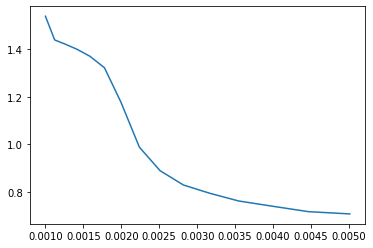

In [36]:
plt.plot(autorec_history.history['lr'], autorec_history.history['loss'])

Optimal learning rate seems to be approx.: 0.012

In [37]:
lr = 0.005

### Deep autorec crossval

In [60]:
import gc
tf.keras.backend.clear_session()
gc.collect()

autorec_mse = []
autorec_mape = []
es = krs.callbacks.EarlyStopping(monitor='val_mape_masked', mode='min', min_delta=0.002, patience=3)

optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
build_params = {
    'optimizer': optimizer,
    'loss': huber_masked,
    'metrics': [mse_masked, mape_masked, 'mae']
}
    
for exd in crossvals:
    autorec_model, mape, mse, autorec_history = conduct_experiment(exd, autorec_multiple_embeddings, preapre_model_data_autorec, build_params=build_params, fit_params={'batch_size': 16, 'epochs': 15, 'callbacks': [es]})
    autorec_mse.append(mse)
    autorec_mape.append(mape)
    
    print(f"MSE: {autorec_mse}")
    print(f"Mape: {autorec_mape}")
    gc.collect()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
userattr_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
modelattr_input (InputLayer)    [(None, 1)]          0                                            
______________________________________________________________________________________________

64083/64083 [==============================] - 11s 179us/sample - loss: 0.9220 - mse_masked: 0.8935 - mape_masked: 0.2763 - mae: 0.6809 - val_loss: 1.4609 - val_mse_masked: 1.4329 - val_mape_masked: 0.4054 - val_mae: 0.9152
Epoch 8/15
64083/64083 [==============================] - 11s 178us/sample - loss: 0.8370 - mse_masked: 0.8091 - mape_masked: 0.2555 - mae: 0.6374 - val_loss: 1.4819 - val_mse_masked: 1.4549 - val_mape_masked: 0.4004 - val_mae: 0.9287
Epoch 9/15
64083/64083 [==============================] - 11s 177us/sample - loss: 0.7922 - mse_masked: 0.7653 - mape_masked: 0.2442 - mae: 0.6153 - val_loss: 1.4804 - val_mse_masked: 1.4546 - val_mape_masked: 0.4027 - val_mae: 0.9296
MSE: [1.4022706]
Mape: [0.3819719]
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0  

65267/65267 [==============================] - 11s 175us/sample - loss: 1.3315 - mse_masked: 1.3064 - mape_masked: 0.3734 - mae: 0.8786 - val_loss: 1.4560 - val_mse_masked: 1.4321 - val_mape_masked: 0.4063 - val_mae: 0.9568
Epoch 5/15
65267/65267 [==============================] - 11s 174us/sample - loss: 1.2076 - mse_masked: 1.1812 - mape_masked: 0.3451 - mae: 0.8233 - val_loss: 1.5371 - val_mse_masked: 1.5100 - val_mape_masked: 0.4263 - val_mae: 0.8950
Epoch 6/15
65267/65267 [==============================] - 12s 190us/sample - loss: 0.9798 - mse_masked: 0.9508 - mape_masked: 0.2898 - mae: 0.7109 - val_loss: 1.5271 - val_mse_masked: 1.4986 - val_mape_masked: 0.3990 - val_mae: 1.0133
Epoch 7/15
65267/65267 [==============================] - 11s 175us/sample - loss: 0.8653 - mse_masked: 0.8367 - mape_masked: 0.2625 - mae: 0.6554 - val_loss: 1.4883 - val_mse_masked: 1.4611 - val_mape_masked: 0.4034 - val_mae: 0.9306
Epoch 8/15
65267/65267 [==============================] - 11s 173us/sam

65928/65928 [==============================] - 14s 211us/sample - loss: 1.4768 - mse_masked: 1.4358 - mape_masked: 0.3960 - mae: 0.9331 - val_loss: 1.4264 - val_mse_masked: 1.3912 - val_mape_masked: 0.3947 - val_mae: 0.8952
Epoch 2/15
65928/65928 [==============================] - 12s 176us/sample - loss: 1.4075 - mse_masked: 1.3740 - mape_masked: 0.3881 - mae: 0.9085 - val_loss: 1.4072 - val_mse_masked: 1.3779 - val_mape_masked: 0.3914 - val_mae: 0.8709
Epoch 3/15
65928/65928 [==============================] - 12s 175us/sample - loss: 1.3612 - mse_masked: 1.3319 - mape_masked: 0.3796 - mae: 0.8911 - val_loss: 1.3989 - val_mse_masked: 1.3736 - val_mape_masked: 0.3808 - val_mae: 0.9457
Epoch 4/15
65928/65928 [==============================] - 11s 173us/sample - loss: 1.2919 - mse_masked: 1.2646 - mape_masked: 0.3651 - mae: 0.8623 - val_loss: 1.4194 - val_mse_masked: 1.3937 - val_mape_masked: 0.3857 - val_mae: 0.8755
Epoch 5/15
65928/65928 [==============================] - 11s 173us/sam

65835/65835 [==============================] - 14s 215us/sample - loss: 1.5042 - mse_masked: 1.4639 - mape_masked: 0.4000 - mae: 0.9425 - val_loss: 1.2822 - val_mse_masked: 1.2426 - val_mape_masked: 0.3526 - val_mae: 0.8675
Epoch 2/15
65835/65835 [==============================] - 12s 181us/sample - loss: 1.4323 - mse_masked: 1.3998 - mape_masked: 0.3945 - mae: 0.9219 - val_loss: 1.2836 - val_mse_masked: 1.2516 - val_mape_masked: 0.3452 - val_mae: 0.8979
Epoch 3/15
65835/65835 [==============================] - 12s 178us/sample - loss: 1.3988 - mse_masked: 1.3718 - mape_masked: 0.3878 - mae: 0.9056 - val_loss: 1.2532 - val_mse_masked: 1.2259 - val_mape_masked: 0.3429 - val_mae: 0.8873
Epoch 4/15
65835/65835 [==============================] - 12s 175us/sample - loss: 1.3536 - mse_masked: 1.3299 - mape_masked: 0.3793 - mae: 0.8892 - val_loss: 1.2337 - val_mse_masked: 1.2067 - val_mape_masked: 0.3405 - val_mae: 0.8436
Epoch 5/15
65835/65835 [==============================] - 11s 174us/sam

66018/66018 [==============================] - 14s 207us/sample - loss: 1.4959 - mse_masked: 1.4550 - mape_masked: 0.4005 - mae: 0.9422 - val_loss: 1.4245 - val_mse_masked: 1.3916 - val_mape_masked: 0.3953 - val_mae: 0.8943
Epoch 2/15
66018/66018 [==============================] - 12s 180us/sample - loss: 1.4316 - mse_masked: 1.3983 - mape_masked: 0.3945 - mae: 0.9221 - val_loss: 1.3709 - val_mse_masked: 1.3443 - val_mape_masked: 0.3810 - val_mae: 0.8730
Epoch 3/15
66018/66018 [==============================] - 12s 178us/sample - loss: 1.3877 - mse_masked: 1.3592 - mape_masked: 0.3860 - mae: 0.9040 - val_loss: 1.3390 - val_mse_masked: 1.3158 - val_mape_masked: 0.3768 - val_mae: 0.8883
Epoch 4/15
66018/66018 [==============================] - 12s 177us/sample - loss: 1.3330 - mse_masked: 1.3074 - mape_masked: 0.3756 - mae: 0.8839 - val_loss: 1.3602 - val_mse_masked: 1.3401 - val_mape_masked: 0.3775 - val_mae: 0.8408
Epoch 5/15
66018/66018 [==============================] - 12s 176us/sam

66100/66100 [==============================] - 14s 208us/sample - loss: 1.4983 - mse_masked: 1.4563 - mape_masked: 0.4015 - mae: 0.9436 - val_loss: 1.3405 - val_mse_masked: 1.3046 - val_mape_masked: 0.3572 - val_mae: 0.9413
Epoch 2/15
66100/66100 [==============================] - 11s 171us/sample - loss: 1.4270 - mse_masked: 1.3924 - mape_masked: 0.3930 - mae: 0.9181 - val_loss: 1.2192 - val_mse_masked: 1.1891 - val_mape_masked: 0.3414 - val_mae: 0.7992
Epoch 3/15
66100/66100 [==============================] - 12s 175us/sample - loss: 1.3821 - mse_masked: 1.3529 - mape_masked: 0.3852 - mae: 0.9020 - val_loss: 1.2397 - val_mse_masked: 1.2143 - val_mape_masked: 0.3446 - val_mae: 0.8812
Epoch 4/15
66100/66100 [==============================] - 12s 175us/sample - loss: 1.3131 - mse_masked: 1.2863 - mape_masked: 0.3711 - mae: 0.8741 - val_loss: 1.2211 - val_mse_masked: 1.1954 - val_mape_masked: 0.3370 - val_mae: 0.7794
Epoch 5/15
66100/66100 [==============================] - 11s 169us/sam

66100/66100 [==============================] - 14s 206us/sample - loss: 1.4955 - mse_masked: 1.4538 - mape_masked: 0.3998 - mae: 0.9402 - val_loss: 1.3155 - val_mse_masked: 1.2758 - val_mape_masked: 0.3578 - val_mae: 0.8985
Epoch 2/15
66100/66100 [==============================] - 12s 184us/sample - loss: 1.4302 - mse_masked: 1.3966 - mape_masked: 0.3940 - mae: 0.9201 - val_loss: 1.2878 - val_mse_masked: 1.2544 - val_mape_masked: 0.3559 - val_mae: 0.8537
Epoch 3/15
66100/66100 [==============================] - 12s 186us/sample - loss: 1.3922 - mse_masked: 1.3634 - mape_masked: 0.3866 - mae: 0.9036 - val_loss: 1.2670 - val_mse_masked: 1.2382 - val_mape_masked: 0.3515 - val_mae: 0.8529
Epoch 4/15
66100/66100 [==============================] - 12s 180us/sample - loss: 1.3440 - mse_masked: 1.3182 - mape_masked: 0.3777 - mae: 0.8870 - val_loss: 1.2881 - val_mse_masked: 1.2610 - val_mape_masked: 0.3487 - val_mae: 0.9070
Epoch 5/15
66100/66100 [==============================] - 11s 174us/sam

66272/66272 [==============================] - 13s 202us/sample - loss: 1.4979 - mse_masked: 1.4571 - mape_masked: 0.3954 - mae: 0.9352 - val_loss: 1.5694 - val_mse_masked: 1.5264 - val_mape_masked: 0.4343 - val_mae: 0.9679
Epoch 2/15
66272/66272 [==============================] - 11s 167us/sample - loss: 1.3946 - mse_masked: 1.3610 - mape_masked: 0.3852 - mae: 0.9023 - val_loss: 1.5433 - val_mse_masked: 1.5073 - val_mape_masked: 0.4227 - val_mae: 1.0026
Epoch 3/15
66272/66272 [==============================] - 11s 168us/sample - loss: 1.3479 - mse_masked: 1.3191 - mape_masked: 0.3767 - mae: 0.8857 - val_loss: 1.5389 - val_mse_masked: 1.5066 - val_mape_masked: 0.4256 - val_mae: 0.9361
Epoch 4/15
66272/66272 [==============================] - 11s 168us/sample - loss: 1.2712 - mse_masked: 1.2446 - mape_masked: 0.3606 - mae: 0.8533 - val_loss: 1.5613 - val_mse_masked: 1.5282 - val_mape_masked: 0.4292 - val_mae: 0.9402
Epoch 5/15
66272/66272 [==============================] - 11s 168us/sam

66408/66408 [==============================] - 14s 213us/sample - loss: 1.4737 - mse_masked: 1.4334 - mape_masked: 0.3952 - mae: 0.9316 - val_loss: 1.4666 - val_mse_masked: 1.4312 - val_mape_masked: 0.4024 - val_mae: 0.9606
Epoch 2/15
66408/66408 [==============================] - 12s 179us/sample - loss: 1.4007 - mse_masked: 1.3678 - mape_masked: 0.3861 - mae: 0.9045 - val_loss: 1.4271 - val_mse_masked: 1.3974 - val_mape_masked: 0.3986 - val_mae: 0.9299
Epoch 3/15
66408/66408 [==============================] - 12s 176us/sample - loss: 1.3552 - mse_masked: 1.3270 - mape_masked: 0.3781 - mae: 0.8886 - val_loss: 1.4119 - val_mse_masked: 1.3855 - val_mape_masked: 0.3951 - val_mae: 0.9086
Epoch 4/15
66408/66408 [==============================] - 12s 179us/sample - loss: 1.2858 - mse_masked: 1.2596 - mape_masked: 0.3641 - mae: 0.8612 - val_loss: 1.4332 - val_mse_masked: 1.4070 - val_mape_masked: 0.4011 - val_mae: 0.8880
Epoch 5/15
66408/66408 [==============================] - 12s 181us/sam

66618/66618 [==============================] - 14s 217us/sample - loss: 1.4913 - mse_masked: 1.4500 - mape_masked: 0.3975 - mae: 0.9391 - val_loss: 1.4422 - val_mse_masked: 1.4040 - val_mape_masked: 0.3791 - val_mae: 0.9856
Epoch 2/15
66618/66618 [==============================] - 12s 181us/sample - loss: 1.4194 - mse_masked: 1.3856 - mape_masked: 0.3907 - mae: 0.9152 - val_loss: 1.3458 - val_mse_masked: 1.3143 - val_mape_masked: 0.3746 - val_mae: 0.9000
Epoch 3/15
66618/66618 [==============================] - 12s 178us/sample - loss: 1.3835 - mse_masked: 1.3556 - mape_masked: 0.3838 - mae: 0.9000 - val_loss: 1.3463 - val_mse_masked: 1.3203 - val_mape_masked: 0.3736 - val_mae: 0.9213
Epoch 4/15
66618/66618 [==============================] - 12s 185us/sample - loss: 1.3333 - mse_masked: 1.3088 - mape_masked: 0.3747 - mae: 0.8837 - val_loss: 1.3402 - val_mse_masked: 1.3158 - val_mape_masked: 0.3709 - val_mae: 0.8567
Epoch 5/15
66618/66618 [==============================] - 13s 190us/sam

In [61]:
autorec_results = pd.DataFrame({
    'autorec_mape': autorec_mape,
    'autorec_mse': autorec_mse
})


In [90]:
autorec_results.to_csv("./notebooks/autorec_results.csv", index=False)

In [48]:
autorec_results = pd.read_csv("./notebooks/autorec_results.csv", index_col=None)

In [62]:
autorec_results[["autorec_mape", "autorec_mse"]]

,autorec_mape,autorec_mse
0,0.381972,1.402271
1,0.416760,1.489394
2,0.397801,1.474884
3,0.396090,1.417282
4,0.346675,1.264648
5,0.331001,1.201078
6,0.387377,1.395671
7,0.400253,1.465100
8,0.396982,1.480704
9,0.391766,1.465591


In [63]:
colab_res[["colab_mape", "colab_mse"]]

,colab_mape,colab_mse
0,0.381724,1.341046
1,0.417127,1.451853
2,0.398994,1.405102
3,0.395755,1.407544
4,0.358347,1.268155
5,0.343120,1.203991
6,0.387410,1.395020
7,0.404051,1.440887
8,0.405730,1.447349
9,0.401230,1.412892


In [64]:
autorec_results.autorec_mse.mean(), colab_res.colab_mse.mean()

(1.405662202835083, 1.3773839950561524)

In [65]:
autorec_results.autorec_mape.mean(), colab_res.colab_mape.mean()

(0.38466755747795106, 0.3893488645553589)

# Compare two models

In [66]:
st.wilcoxon(autorec_results.autorec_mape, colab_res.colab_mape, correction=True, alternative='two-sided')

WilcoxonResult(statistic=5.0, pvalue=0.024932455602863092)

In [45]:
st.wilcoxon(autorec_results.autorec_mse, colab_res.colab_mse, correction=True)

WilcoxonResult(statistic=4.0, pvalue=0.019058891601730438)

In [46]:
st.mannwhitneyu(autorec_results.autorec_mse, colab_res.colab_mse, use_continuity=True)

MannwhitneyuResult(statistic=29.0, pvalue=0.06061225150645831)

In [47]:
st.mannwhitneyu(autorec_results.autorec_mape, colab_res.colab_mape, use_continuity=True)

MannwhitneyuResult(statistic=42.0, pvalue=0.28537519402908695)

In [45]:
st.kruskal(autorec_results.autorec_mape, colab_res.autorec_mape)

AttributeError: 'DataFrame' object has no attribute 'autorec_mape'

In [87]:
st.ttest_ind(autorec_results.autorec_mse, colab_res.colab_mse, equal_var=False)

Ttest_indResult(statistic=6.504160376112249, pvalue=8.209933725459241e-06)

In [88]:
st.ttest_ind(autorec_results.autorec_mape, colab_res.colab_mape, equal_var=False)

Ttest_indResult(statistic=-0.6909034172275881, pvalue=0.49870164935874917)